In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('dataset/houseprice.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea",
                                         "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()

### Data exploration

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB


### Identify categorical features and continuous features

In [6]:
for i in df.columns:
    print(f"Column {i} has total of {len(df[i].unique())}")

Column MSSubClass has total of 15
Column MSZoning has total of 5
Column LotFrontage has total of 110
Column LotArea has total of 869
Column Street has total of 2
Column LotShape has total of 4
Column YearBuilt has total of 112
Column 1stFlrSF has total of 678
Column 2ndFlrSF has total of 368
Column SalePrice has total of 597


#### Create TotalYears feature

In [7]:
import datetime
df["TotalYears"] = datetime.datetime.now().year - df["YearBuilt"]

In [8]:
df.drop("YearBuilt", axis=1, inplace=True)

### Split features between categorical and continuous(or numerical)

In [9]:
cat_features=["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature="SalePrice"

In [10]:
from sklearn.preprocessing import LabelEncoder
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])

### Stacking and Converting Into Tensors

In [11]:
cat_features=np.stack([df['MSSubClass'],df['MSZoning'],df['Street'],df['LotShape']],1)
cat_features

array([[5, 3, 1, 3],
       [0, 3, 1, 3],
       [5, 3, 1, 0],
       ...,
       [6, 3, 1, 3],
       [0, 3, 1, 3],
       [0, 3, 1, 3]])

### Convert numpy to Tensors

In [12]:
import torch
cat_features=torch.tensor(cat_features,dtype=torch.int64)
cat_features

tensor([[5, 3, 1, 3],
        [0, 3, 1, 3],
        [5, 3, 1, 0],
        ...,
        [6, 3, 1, 3],
        [0, 3, 1, 3],
        [0, 3, 1, 3]])

#### Create continuous variable

In [13]:
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)


### Stacking continuous variable to a tensor

In [14]:
cont_values=np.stack([df[i].values for i in cont_features],axis=1)
cont_values=torch.tensor(cont_values,dtype=torch.float)
cont_values

tensor([[   65.,  8450.,   856.,   854.,    22.],
        [   80.,  9600.,  1262.,     0.,    49.],
        [   68., 11250.,   920.,   866.,    24.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    84.],
        [   68.,  9717.,  1078.,     0.,    75.],
        [   75.,  9937.,  1256.,     0.,    60.]])

### Tensor For Dependent Feature 

In [15]:
y=torch.tensor(df['SalePrice'].values,dtype=torch.float).reshape(-1,1)

## Embedding Size For Categorical columns

In [16]:
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [17]:
cat_dims

[15, 5, 2, 4]

### Thumb rule: Output dimension should be set based on the input dimension [min(50, feature_dimension//2)]

In [18]:
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [19]:
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

### Creating NN

In [20]:
##### Create a Feed Forward Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
class FeedForwardNN(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [21]:
len(cont_features)

5

In [22]:
torch.manual_seed(100)
model=FeedForwardNN(embedding_dim,len(cont_features),1,[100,50],p=0.4)

In [23]:
model

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Define Loss and Optimiser

In [24]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [25]:
df.shape

(1201, 10)

In [26]:
cont_values

tensor([[   65.,  8450.,   856.,   854.,    22.],
        [   80.,  9600.,  1262.,     0.,    49.],
        [   68., 11250.,   920.,   866.,    24.],
        ...,
        [   66.,  9042.,  1188.,  1152.,    84.],
        [   68.,  9717.,  1078.,     0.,    75.],
        [   75.,  9937.,  1256.,     0.,    60.]])

In [27]:
cont_values.shape

torch.Size([1201, 5])

In [28]:
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat_features[:batch_size-test_size]
test_categorical=cat_features[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [29]:
len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(1020, 180, 1020, 180, 1020, 180)

### Training the model

In [30]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(train_categorical,train_cont)
    loss=torch.sqrt(loss_function(y_pred,y_train)) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 200496.765625
Epoch number: 11 and the loss : 200493.578125
Epoch number: 21 and the loss : 200489.125
Epoch number: 31 and the loss : 200482.546875
Epoch number: 41 and the loss : 200473.234375
Epoch number: 51 and the loss : 200462.140625
Epoch number: 61 and the loss : 200447.3125
Epoch number: 71 and the loss : 200429.125
Epoch number: 81 and the loss : 200409.15625
Epoch number: 91 and the loss : 200382.0625
Epoch number: 101 and the loss : 200354.703125
Epoch number: 111 and the loss : 200322.890625
Epoch number: 121 and the loss : 200290.25
Epoch number: 131 and the loss : 200254.09375
Epoch number: 141 and the loss : 200212.8125
Epoch number: 151 and the loss : 200162.34375
Epoch number: 161 and the loss : 200116.0
Epoch number: 171 and the loss : 200057.453125
Epoch number: 181 and the loss : 200002.0625
Epoch number: 191 and the loss : 199942.40625
Epoch number: 201 and the loss : 199877.234375
Epoch number: 211 and the loss : 199808.1875
Epoch 

### Ploting Loss againgst epoch

In [32]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 6.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Text(0.5, 0, 'epoch')

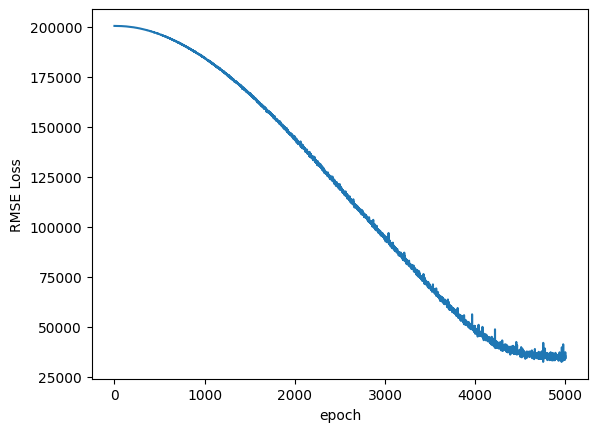

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epochs), [loss.detach().numpy() if hasattr(loss, 'detach') else loss for loss in final_losses])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

### Validate the Test Data

In [37]:

y_pred=""
with torch.no_grad():
    y_pred=model(test_categorical,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test))
print('RMSE: {}'.format(loss))

RMSE: 47750.21484375


In [38]:
data_verify=pd.DataFrame(y_test.tolist(),columns=["Test"])

In [39]:
data_predicted=pd.DataFrame(y_pred.tolist(),columns=["Prediction"])

### Comparing The prediction against the actual data

In [40]:
final_output=pd.concat([data_verify,data_predicted],axis=1)
final_output['Difference']=final_output['Test']-final_output['Prediction']
final_output.head()

,Test,Prediction,Difference
0,130000.0,137630.18750,-7630.18750
1,138887.0,149623.53125,-10736.53125
2,175500.0,149617.53125,25882.46875
3,195000.0,247700.31250,-52700.31250
4,142500.0,149790.90625,-7290.90625


### Saving the model

In [42]:
torch.save(model,'HousePrice.pt')
torch.save(model.state_dict(),'HouseWeights.pt')

### Loading the model

In [43]:
embs_size=[(15, 8), (5, 3), (2, 1), (4, 2)]
model1=FeedForwardNN(embs_size,5,1,[100,50],p=0.4)

In [44]:
model1.load_state_dict(torch.load('HouseWeights.pt'))

<All keys matched successfully>

In [45]:
model1.eval()

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(15, 8)
    (1): Embedding(5, 3)
    (2): Embedding(2, 1)
    (3): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)